# Robótica Móvel - Trabalho Prático 1 - Ferramentas e Transformações 

## Aluno: Cayo Fábio de Almeida Sousa
## Matrícula: 2024710608

### Para o código a seguir, executar de forma sequencial.
### Atividade 1: [0,5 pts] Crie uma nova cena, adicione um robô móvel (e.g., Pioneer 3DX) e outros cinco elementos diferentes (e.g., móveis, pessoas, outros robôs, etc) espalhados pelo ambiente.
### R: Abrir o arquivo com a Cena1 - Trabalho Pratico 1
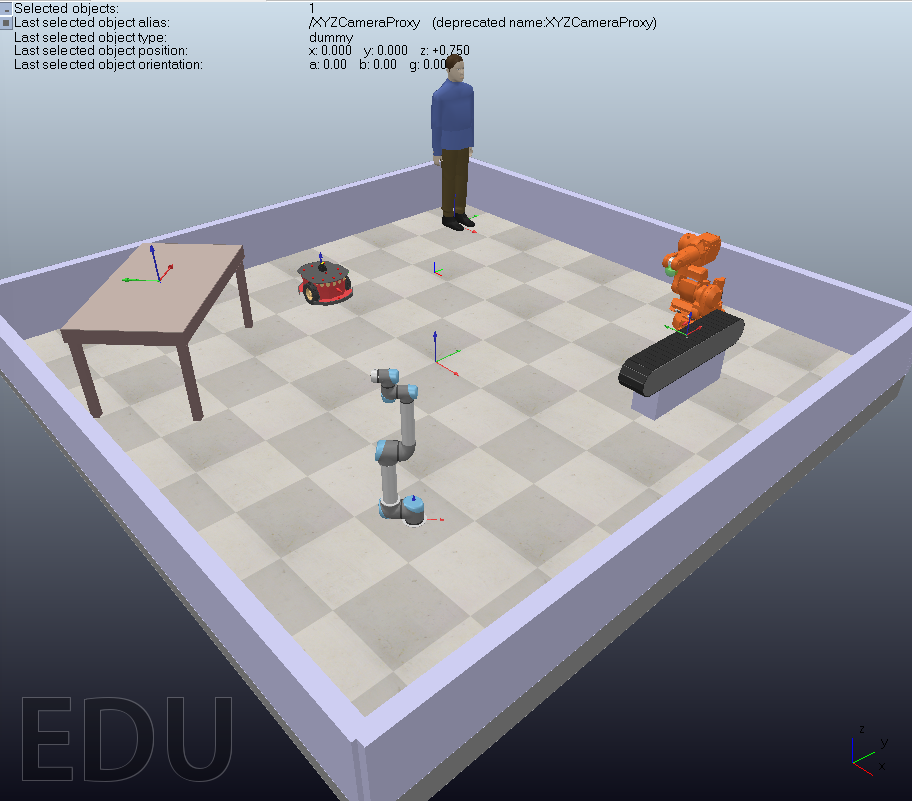

### Atividade 2: [0,5 pts] Defina os sistemas de coordenadas de todos os itens (você deve adicioná-los na cena  e afixar aos elementos para facilitar a visualização). Em seguida, você deverá representar os  sistemas de coordenadas e as transformações entre eles (não precisa ser todos para todos)  utilizando um diagrama, similar à figura abaixo (pode ser uma versão mais simplificada). 
### R: Diagrama de sistemas de coordenadas e transformações.
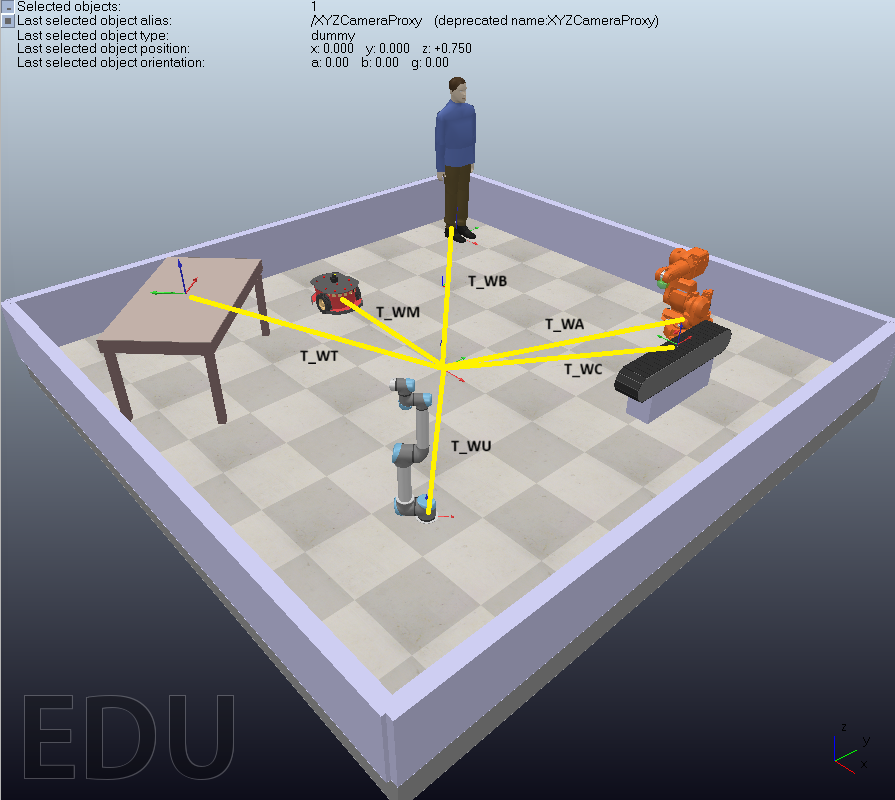
#### LEGENDA: 
    -T_WM: HTM do mundo para o robô móvel
    -T_WT: HTM do mundo para a mesa
    -T_WB: HTM do mundo para o Bill
    -T_WA: HTM do mundo para o robô ABB - IRB140
    -T_WC: HTM do mundo para a esteira (conveyor)
    -T_WU: HTM do mundo para o robô UR5
### Atividade 3: [1,0 pt] Considerando que a configuração do robô no referencial global é conhecida e dada por q = [𝑥,𝑦,𝜃], defina as matrizes de transformação homogêneas que representam as posições de todos os outros elementos da cena no referencial local do robô. Escreva um script que plota esses referenciais e os relacionamentos (vetor) entre eles (dica: use os códigos vistos em aula como base). Para os cálculos, as posições globais dos elementos podem ser recuperadas utilizando-se a RemoteAPI. 
### R: Os trechos a seguir, responde a questão 3.



In [26]:
# ==============================================================================
# 1. IMPORTAÇÕES DE BIBLIOTECAS
# ==============================================================================
import traceback
import matplotlib.pyplot as plt
import numpy as np
import time
import math

plt.close('all')
%matplotlib inline

# Configura o formato global do NumPy
np.set_printoptions(precision=2, suppress=True)

# ==============================================================================
# 2. FUNÇÕES DE CONVERSÃO MATEMÁTICA E CINEMÁTICA
# ==============================================================================

def Rz(theta):
    """
    Cria uma matriz de rotação 3x3 em torno do eixo Z.
    Args:
        theta (float): Ângulo de rotação em radianos.
    Returns:
        np.ndarray: A matriz de rotação 3x3.
    """
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0            ,  0            , 1]
    ])

def yaw_to_quaternion(theta):
    """
    Converte um ângulo de yaw (rotação em Z) para um quatérnio [qx, qy, qz, qw].
    Esta função assume que os ângulos de pitch e roll são zero, sendo ideal
    para robôs móveis planos.
    Args:
        theta (float): Ângulo de yaw em radianos.
    Returns:
        list: O quatérnio resultante no formato [qx, qy, qz, qw].
    """
    half_theta = theta / 2.0
    qx = 0.0
    qy = 0.0
    qz = np.sin(half_theta)
    qw = np.cos(half_theta)
    return [qx, qy, qz, qw]

def quat_to_R(qx, qy, qz, qw):
    """
    Converte um quatérnio [qx, qy, qz, qw] em uma matriz de rotação 3x3.
    Args:
        qx, qy, qz, qw (float): Componentes do quatérnio.
    Returns:
        np.ndarray: A matriz de rotação 3x3 correspondente.
    """
    # Normaliza o quatérnio para garantir que seja unitário (condição para a fórmula)
    norm = np.sqrt(qx*qx + qy*qy + qz*qz + qw*qw)
    if norm == 0:
        raise ValueError("Quatérnio nulo não pode ser convertido.")
    qx, qy, qz, qw = qx/norm, qy/norm, qz/norm, qw/norm
    
    # Aplica a fórmula de conversão de quatérnio para matriz de rotação
    R = np.array([
        [1 - 2*(qy*qy + qz*qz),   2*(qx*qy - qz*qw),   2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw),   1 - 2*(qx*qx + qz*qz),   2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw),   2*(qy*qz + qx*qw),   1 - 2*(qx*qx + qy*qy)]
    ], dtype=float)
    return R

def htm_se3_from_pose(pose):
    """
    Monta uma Matriz de Transformação Homogênea (HTM) 4x4 a partir de um vetor de pose.
    Args:
        pose (list or tuple): Vetor de pose no formato [x, y, z, qx, qy, qz, qw].
    Returns:
        np.ndarray: A matriz de transformação homogênea 4x4 (^W T_R).
    """
    x, y, z, qx, qy, qz, qw = pose
    R = quat_to_R(qx, qy, qz, qw)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3]  = [x, y, z]
    return T

def xy_theta_from_T(T):
    """
    Extrai a pose 2D (x, y, theta) de uma Matriz de Transformação Homogênea 4x4.
    Args:
        T (np.ndarray): A matriz de transformação homogênea 4x4.
    Returns:
        tuple: Uma tupla contendo (x, y, theta).
    """
    x = T[0, 3]
    y = T[1, 3]
    theta = np.arctan2(T[1, 0], T[0, 0])
    return x, y, theta

def transform_laser_points_to_world(laser_data, T_world_sensor, max_sensor_range=5.0):
    """
    laser_data: iteravel de (ang,dist) no frame do sensor
    T_world_robot: ^W T_R (4x4)
    T_robot_sensor: ^R T_S (4x4)
    Retorna: pontos (N,3) no mundo.
    """
    XYZ = []
    for ang, dist in laser_data:
        if (max_sensor_range - dist) > 0.1:  # filtra no-hit
            xs = dist * math.cos(ang)
            ys = dist * math.sin(ang)
            ps = np.array([xs, ys, 0.0, 1.0])
            pw = T_world_sensor @ ps
            XYZ.append(pw[:3])
    if not XYZ:
        return np.empty((0,3))
    return np.vstack(XYZ)


# ==============================================================================
# 3. FUNÇÕES DE INTERAÇÃO COM A SIMULAÇÃO
# ==============================================================================

def set_mobile_xytheta(sim, handle, x, y, theta, z=None):
    """
    Posiciona um objeto (robô móvel) no mundo da simulação com a pose 2D (x, y, theta).

    Args:
        sim: Objeto da API do simulador (ex: CoppeliaSim).
        handle (int): O handle do objeto a ser posicionado.
        x (float): Coordenada X no mundo.
        y (float): Coordenada Y no mundo.
        theta (float): Ângulo de orientação (yaw) em radianos.
        z (float, optional): Coordenada Z. Se for None, a altura atual é preservada.
    """
    if z is None:
        current_pose = sim.getObjectPose(handle, -1)
        z = current_pose[2]

    qx, qy, qz, qw = yaw_to_quaternion(theta)
    new_pose = [x, y, z, qx, qy, qz, qw]
    sim.setObjectPose(handle, -1, new_pose)


# ==============================================================================
# 4. FUNÇÕES DE VISUALIZAÇÃO
# ==============================================================================

def plot_frame(Porg, R, axis_size=0.7, c=['r', 'g']):
    """
    Plota um referencial 2D (eixos X e Y) em uma figura Matplotlib.

    Args:
        Porg (list or np.ndarray): Ponto de origem do referencial [x, y].
        R (np.ndarray): Matriz de rotação 2x2 ou 3x3 que define a orientação.
        axis_size (float, optional): Comprimento dos eixos a serem plotados.
        c (list, optional): Lista de cores para os eixos [cor_eixo_x, cor_eixo_y].
    """
    Rx = R[:2, 0] / np.linalg.norm(R[:2, 0])
    Ry = R[:2, 1] / np.linalg.norm(R[:2, 1])

    plt.quiver(*Porg[:2], *Rx * axis_size, color=c[0], angles='xy', scale_units='xy', scale=1)
    plt.quiver(*Porg[:2], *Ry * axis_size, color=c[1], angles='xy', scale_units='xy', scale=1)

def draw_laser_world_xy(ax, XYZ_world, T_world_robot, T_world_sensor, lim=5.0):
    """Acrescenta os pontos do Hokuyo ao eixo ax (sem limpar)."""
    # pontos (projeção XY)
    if XYZ_world.size:
        ax.plot(XYZ_world[:,0], XYZ_world[:,1], 'o', color='tab:blue', markersize=2)

    # robô (opcional marcar sempre)
    xr, yr, thetar = xy_theta_from_T(T_world_robot)
    #ax.plot(xr, yr, 'ks', markersize=5)

    # sensor (opcional marcar sempre)
    xs, ys, thetas = xy_theta_from_T(T_world_sensor)
    ax.plot(xs, ys, 'o',  color='k', markersize=5)

    # configurações do gráfico (coloquei só uma vez fora do loop, mas pode deixar aqui também)
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_xlabel('x_W [m]')
    ax.set_ylabel('y_W [m]')
    ax.set_title('Leituras do Sensor (XY no mundo)')
    ax.grid(True, linestyle='--', alpha=0.3)

    plt.pause(0.001)  # dá tempo pro matplotlib atualizar

print('Bibliotecas e funções carregadas!')

Bibliotecas e funções carregadas!


In [27]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print('Inicialização...')
    
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)
    sim.step()

    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
        sim.step()

    # Handles - nomes dos objetos na cena
    mobileRobot = 'PioneerP3DX'
    sensor_base = '/' + mobileRobot + '/fastHokuyo'  # base do sensor (modelo fastHokuyo)
    robotArm1   = 'UR5'
    robotArm2   = 'IRB140'
    Table       = 'customizableTable'
    Bill        = 'Bill'
    Conveyor    = 'conveyor'
    
    # The new API uses sim.getObject to get handles. The path starts with '/'
    handleMobileRobot = sim.getObject('/' + mobileRobot)
    l_wheel           = sim.getObject('/' + mobileRobot + '/leftMotor')
    r_wheel           = sim.getObject('/' + mobileRobot + '/rightMotor')
    sensorHandle      = sim.getObject(sensor_base)
    handleRobotArm1   = sim.getObject('/' + robotArm1)
    handleRobotArm2   = sim.getObject('/' + robotArm2)
    handleTable       = sim.getObject('/' + Table)
    handleBill        = sim.getObject('/' + Bill)
    handleConveyor    = sim.getObject('/' + Conveyor)

    #Posiciona o robô em uma pose inicial
    set_mobile_xytheta(sim, handleMobileRobot, x=-1.5, y=0, theta=np.deg2rad(0))
    sim.step()
    
    # Pega a pose relativa ao mundo (-1 indica world frame)
    poseMobileRobot = sim.getObjectPose(handleMobileRobot, -1)
    poseRobotArm1   = sim.getObjectPose(handleRobotArm1, -1)
    poseRobotArm2   = sim.getObjectPose(handleRobotArm2, -1)
    poseTable       = sim.getObjectPose(handleTable, -1)
    poseBill        = sim.getObjectPose(handleBill, -1)
    poseConveyor    = sim.getObjectPose(handleConveyor, -1)
    sim.step()
    
except Exception as e:
    print(f"An error occurred: {e}")

Inicialização...


Pose de todos os objetos no formato (x, y, z, qx, qy, qz, qw):

Pose do robô móvel: [-1.5, 0.0, 0.13879306614398956, 0.0, 0.0, 0.0, 1.0] 

Pose do UR5: [1.25, -1.25, 0.0, 0.0, 0.0, 0.3826834323651139, 0.9238795325112767] 

Pose do IRB140: [1.0, 2.0, 0.0775, 0.0, 0.0, -0.7071067811865839, 0.7071067811865112] 

Pose da mesa: [-1.25, -1.5, 0.7, 0.0, 0.0, 0.9238795325113164, 0.38268343236501823] 

Pose do Bill: [-2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0] 

Pose do Conveyor: [1.5, 1.0, 0.465, 0.0, 0.0, 0.7071067811865848, 0.7071067811865103] 

Matrizes de transformação homogênea dos objetos com relação ao mundo: 

HTM world_mobile (SE(3), 4x4):
 [[ 1.    0.    0.   -1.5 ]
 [ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.14]
 [ 0.    0.    0.    1.  ]] 

HTM world_UR5 (SE(3), 4x4):
 [[ 0.71 -0.71  0.    1.25]
 [ 0.71  0.71  0.   -1.25]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]] 

HTM world_IRB140 (SE(3), 4x4):
 [[-0.    1.    0.    1.  ]
 [-1.   -0.   -0.    2.  ]
 [-0.    0.    1.    

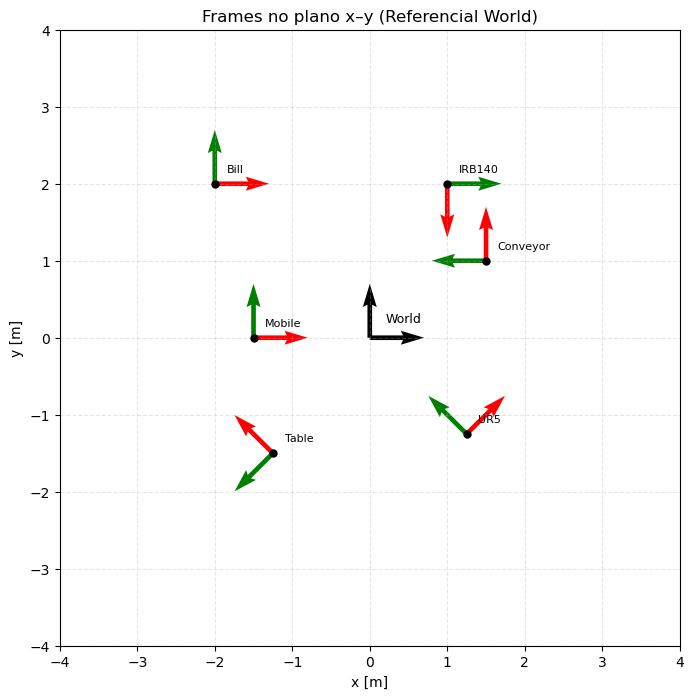

In [28]:
    # Prints das poses organizados
    print("Pose de todos os objetos no formato (x, y, z, qx, qy, qz, qw):\n")
    print("Pose do robô móvel:", poseMobileRobot, "\n")
    print("Pose do UR5:", poseRobotArm1, "\n")
    print("Pose do IRB140:", poseRobotArm2, "\n")
    print("Pose da mesa:", poseTable, "\n")
    print("Pose do Bill:", poseBill, "\n")
    print("Pose do Conveyor:", poseConveyor, "\n")
    
    # Cálculo das HTMs em relação ao mundo
    T_world_mobile   = htm_se3_from_pose(poseMobileRobot)  # 4x4
    T_world_ur5      = htm_se3_from_pose(poseRobotArm1)
    T_world_irb140   = htm_se3_from_pose(poseRobotArm2)
    T_world_table    = htm_se3_from_pose(poseTable)
    T_world_bill     = htm_se3_from_pose(poseBill)
    T_world_conveyor = htm_se3_from_pose(poseConveyor)

    # Prints das HTMs organizados
    print("Matrizes de transformação homogênea dos objetos com relação ao mundo: \n")
    print("HTM world_mobile (SE(3), 4x4):\n", T_world_mobile, "\n")
    print("HTM world_UR5 (SE(3), 4x4):\n", T_world_ur5, "\n")
    print("HTM world_IRB140 (SE(3), 4x4):\n", T_world_irb140, "\n")
    print("HTM world_Table (SE(3), 4x4):\n", T_world_table, "\n")
    print("HTM world_Bill (SE(3), 4x4):\n", T_world_bill, "\n")
    print("HTM world_Conveyor (SE(3), 4x4):\n", T_world_conveyor, "\n")

    # ---------------------------------------------------------
    # Extrair θ (yaw) e (x,y) das HTMs e plotar
    # ---------------------------------------------------------
    
    # Lista (nome, HTM). Aceita HTM 4×4 (SE(3))
    objetos = [
        ("Mobile",   T_world_mobile),
        ("UR5",      T_world_ur5),
        ("IRB140",   T_world_irb140),
        ("Table",    T_world_table),
        ("Bill",     T_world_bill),
        ("Conveyor", T_world_conveyor),
    ]
    
    plt.figure(figsize=(8, 8))
    
    # Frame do mundo
    plot_frame(np.array([0.0, 0.0, 0.0]), Rz(0.0), c=['k','k'])
    plt.text(0.2, 0.2, 'World', fontsize=9)
    
    for i, (nome, T) in enumerate(objetos):
        # Extrai (x,y) e elementos da rotação para obter θ = atan2(r10, r00)
        if T.shape == (4,4):
            x, y = T[0,3], T[1,3]
            r00, r10 = T[0,0], T[1,0]
        else:  # (3,3)
            x, y = T[0,2], T[1,2]
            r00, r10 = T[0,0], T[1,0]
    
        theta = np.arctan2(r10, r00)     # yaw (rotação em z)
        Porg  = np.array([x, y, 0.0])    # origem no plano
        R2D   = Rz(theta)                # rotação planar (usa só Rz e plot_frame)
    
        # Plota o frame 2D com X vermelho e Y verde
        plot_frame(Porg, R2D, c=['r','g'])
    
        # Marca o ponto dos frames e rótulo
        plt.plot(x, y, 'o', color='k', markersize=5)
        plt.text(x + 0.15, y + 0.15, f'{nome}', fontsize=8)
    
    plt.axis((-4, 4, -4, 4))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Frames no plano x–y (Referencial World)')
    plt.show()

Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):

HTM mobile_UR5 (SE(3), 4x4):
 [[ 0.71 -0.71  0.    2.75]
 [ 0.71  0.71  0.   -1.25]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_IRB140 (SE(3), 4x4):
 [[-0.    1.    0.    2.5 ]
 [-1.   -0.    0.    2.  ]
 [ 0.    0.    1.   -0.06]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Table (SE(3), 4x4):
 [[-0.71 -0.71  0.    0.25]
 [ 0.71 -0.71  0.   -1.5 ]
 [ 0.    0.    1.    0.56]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Bill (SE(3), 4x4):
 [[ 1.    0.    0.   -0.5 ]
 [ 0.    1.    0.    2.  ]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Conveyor (SE(3), 4x4):
 [[-0.   -1.    0.    3.  ]
 [ 1.   -0.    0.    1.  ]
 [ 0.    0.    1.    0.33]
 [ 0.    0.    0.    1.  ]] 



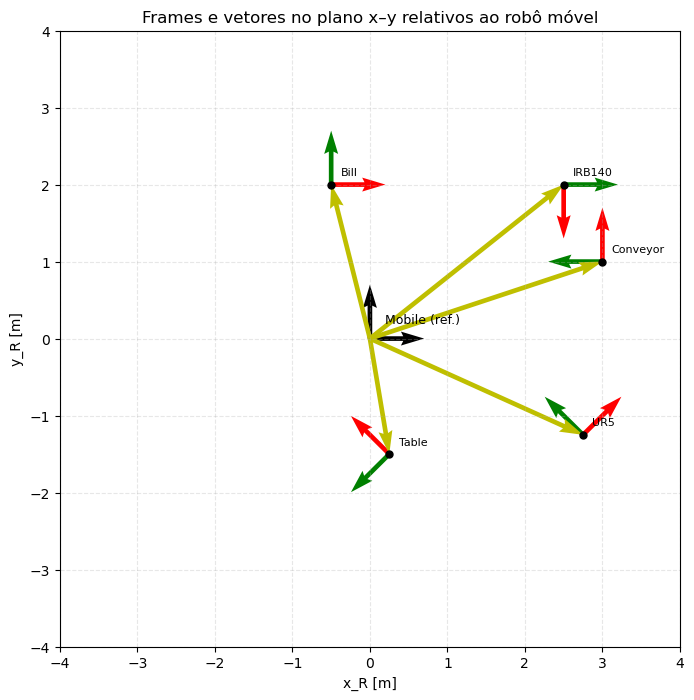

Fim da Atividade 3


In [29]:
T_mobile_world = np.linalg.inv(T_world_mobile)

# ^R T_i = ( ^R T_W )( ^W T_i ) = ( ^W T_R )^{-1}( ^W T_i )
T_mobile_ur5      = T_mobile_world @ T_world_ur5
T_mobile_irb140   = T_mobile_world @ T_world_irb140
T_mobile_table    = T_mobile_world @ T_world_table
T_mobile_bill     = T_mobile_world @ T_world_bill
T_mobile_conveyor = T_mobile_world @ T_world_conveyor

print("Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):\n")
print("HTM mobile_UR5 (SE(3), 4x4):\n",      T_mobile_ur5,      "\n")
print("HTM mobile_IRB140 (SE(3), 4x4):\n",   T_mobile_irb140,   "\n")
print("HTM mobile_Table (SE(3), 4x4):\n",    T_mobile_table,    "\n")
print("HTM mobile_Bill (SE(3), 4x4):\n",     T_mobile_bill,     "\n")
print("HTM mobile_Conveyor (SE(3), 4x4):\n", T_mobile_conveyor, "\n")

# --------- 2) Plot no referencial do robô + 3) vetores OR->Oi ---------
objetos_R = [
    ("UR5",      T_mobile_ur5),
    ("IRB140",   T_mobile_irb140),
    ("Table",    T_mobile_table),
    ("Bill",     T_mobile_bill),
    ("Conveyor", T_mobile_conveyor),
]

plt.figure(figsize=(8, 8))

# Frame do robô como origem
plot_frame(np.array([0.0, 0.0, 0.0]), Rz(0.0), c=['k','k'])
plt.text(0.2, 0.2, 'Mobile (ref.)', fontsize=9)

for nome, T in objetos_R:
    x, y, theta = xy_theta_from_T(T)
    Porg  = np.array([x, y, 0.0])
    R2D   = Rz(theta)

    plot_frame(Porg, R2D, c=['r','g'])
    plt.plot(x, y, 'o', color='k', markersize=5)
    plt.text(x + 0.12, y + 0.12, f'{nome}', fontsize=8)

    # vetor OR -> Oi
    plt.quiver(0.0, 0.0, x, y, color='y', angles='xy', scale_units='xy', scale=1)

plt.axis((-4, 4, -4, 4))
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel('x_R [m]')
plt.ylabel('y_R [m]')
plt.title('Frames e vetores no plano x–y relativos ao robô móvel')
plt.show()

print("Fim da Atividade 3")

### Atividade 4: [0,5 pts] Coloque o robô em outras três posições diferentes da cena e faça os respectivos plots (referenciais e relacionamentos), verificando que a implementação funciona para diferentes casos. Lembre-se de também variar a orientação do robô em relação aos elementos, por exemplo, colocando ele de frente, de lado e de costas. 
### R: Os trechos a seguir posicionam o robô em 3 outras poses e plotam os referenciais e relacionamentos resultantes.

#### -Pose 1 (x, y, theta): (-1.5, 1, 90 graus)

Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):

HTM mobile_UR5 (SE(3), 4x4):
 [[ 0.71  0.71  0.   -2.25]
 [-0.71  0.71  0.   -2.75]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_IRB140 (SE(3), 4x4):
 [[-1.   -0.    0.    1.  ]
 [ 0.   -1.    0.   -2.5 ]
 [ 0.    0.    1.   -0.06]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Table (SE(3), 4x4):
 [[ 0.71 -0.71  0.   -2.5 ]
 [ 0.71  0.71  0.   -0.25]
 [ 0.    0.    1.    0.56]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Bill (SE(3), 4x4):
 [[-0.    1.    0.    1.  ]
 [-1.   -0.    0.    0.5 ]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Conveyor (SE(3), 4x4):
 [[ 1.   -0.    0.   -0.  ]
 [ 0.    1.    0.   -3.  ]
 [ 0.    0.    1.    0.33]
 [ 0.    0.    0.    1.  ]] 



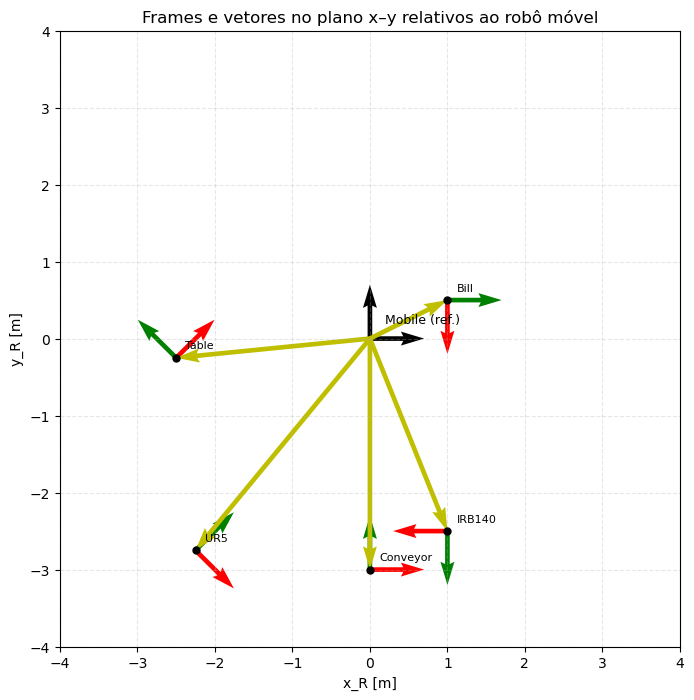

In [30]:
    # Exemplo 1: posicionar em um ponto único
    set_mobile_xytheta(sim, handleMobileRobot, x=-1.5, y=1.0, theta=np.deg2rad(90))
    sim.step()
    
    poseMobileRobot = sim.getObjectPose(handleMobileRobot, -1)
    T_world_mobile   = htm_se3_from_pose(poseMobileRobot) 

    T_mobile_world = np.linalg.inv(T_world_mobile)
    
    # ^R T_i = (^R T_W) (^W T_i) = ( ^W T_R )^{-1}  (^W T_i)
    T_mobile_ur5      = T_mobile_world @ T_world_ur5
    T_mobile_irb140   = T_mobile_world @ T_world_irb140
    T_mobile_table    = T_mobile_world @ T_world_table
    T_mobile_bill     = T_mobile_world @ T_world_bill
    T_mobile_conveyor = T_mobile_world @ T_world_conveyor
    
    # (opcional) imprimir as HTMs relativas ao robô
    print("Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):\n")
    print("HTM mobile_UR5 (SE(3), 4x4):\n",      T_mobile_ur5,      "\n")
    print("HTM mobile_IRB140 (SE(3), 4x4):\n",   T_mobile_irb140,   "\n")
    print("HTM mobile_Table (SE(3), 4x4):\n",    T_mobile_table,    "\n")
    print("HTM mobile_Bill (SE(3), 4x4):\n",     T_mobile_bill,     "\n")
    print("HTM mobile_Conveyor (SE(3), 4x4):\n", T_mobile_conveyor, "\n")

    # --------- 2) Plot no referencial do robô + 3) vetores OR->Oi ---------
    objetos_R = [
    ("UR5",      T_mobile_ur5),
    ("IRB140",   T_mobile_irb140),
    ("Table",    T_mobile_table),
    ("Bill",     T_mobile_bill),
    ("Conveyor", T_mobile_conveyor),
]
    
    plt.figure(figsize=(8, 8))
    
    # Frame do robô como origem do gráfico
    plot_frame(np.array([0.0, 0.0, 0.0]), Rz(0.0), c=['k','k'])
    plt.text(0.2, 0.2, 'Mobile (ref.)', fontsize=9)
    
    for nome, T in objetos_R:
        x, y, theta = xy_theta_from_T(T)
        Porg  = np.array([x, y, 0.0])
        R2D   = Rz(theta)
    
        # frame do objeto (X vermelho, Y verde)
        plot_frame(Porg, R2D, c=['r','g'])
    
        # marcador e rótulo
        plt.plot(x, y, 'o', color='k', markersize=5)
        plt.text(x + 0.12, y + 0.12, f'{nome}', fontsize=8)
    
        # --- vetor OR -> Oi (transformação do objeto no plano do robô) ---
        # vetor é simplesmente (x,y) no referencial do robô
        plt.quiver(0.0, 0.0, x, y, color='y', angles='xy', scale_units='xy', scale=1)
    
    plt.axis((-4, 4, -4, 4))
    # Ajuste manual de janela, se quiser:
    # plt.axis((-5, 5, -5, 5))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('x_R [m]')   # eixos no frame do robô
    plt.ylabel('y_R [m]')
    plt.title('Frames e vetores no plano x–y relativos ao robô móvel')
    plt.show()


#### -Pose 2 (x, y, theta): (1.5, 0, 180 graus)

Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):

HTM mobile_UR5 (SE(3), 4x4):
 [[-0.71  0.71  0.    0.25]
 [-0.71 -0.71  0.    1.25]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_IRB140 (SE(3), 4x4):
 [[ 0.   -1.    0.    0.5 ]
 [ 1.    0.    0.   -2.  ]
 [ 0.    0.    1.   -0.06]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Table (SE(3), 4x4):
 [[ 0.71  0.71  0.    2.75]
 [-0.71  0.71  0.    1.5 ]
 [ 0.    0.    1.    0.56]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Bill (SE(3), 4x4):
 [[-1.    0.    0.    3.5 ]
 [-0.   -1.    0.   -2.  ]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Conveyor (SE(3), 4x4):
 [[ 0.    1.    0.    0.  ]
 [-1.    0.    0.   -1.  ]
 [ 0.    0.    1.    0.33]
 [ 0.    0.    0.    1.  ]] 



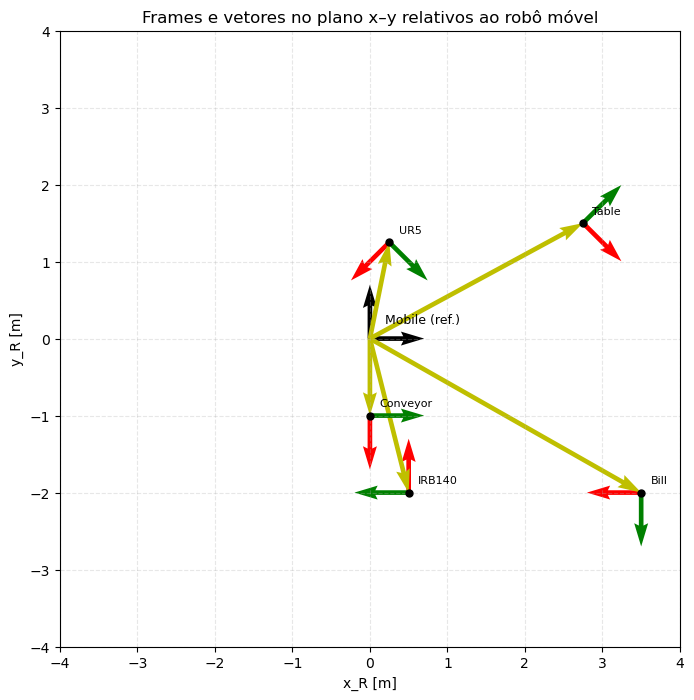

In [31]:
    # Exemplo 1: posicionar em um ponto único
    set_mobile_xytheta(sim, handleMobileRobot, x=1.5, y=0, theta=np.deg2rad(180))
    sim.step()
    
    poseMobileRobot = sim.getObjectPose(handleMobileRobot, -1)
    T_world_mobile   = htm_se3_from_pose(poseMobileRobot) 

    T_mobile_world = np.linalg.inv(T_world_mobile)
    
    # ^R T_i = (^R T_W) (^W T_i) = ( ^W T_R )^{-1}  (^W T_i)
    T_mobile_ur5      = T_mobile_world @ T_world_ur5
    T_mobile_irb140   = T_mobile_world @ T_world_irb140
    T_mobile_table    = T_mobile_world @ T_world_table
    T_mobile_bill     = T_mobile_world @ T_world_bill
    T_mobile_conveyor = T_mobile_world @ T_world_conveyor
    
    # (opcional) imprimir as HTMs relativas ao robô
    print("Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):\n")
    print("HTM mobile_UR5 (SE(3), 4x4):\n",      T_mobile_ur5,      "\n")
    print("HTM mobile_IRB140 (SE(3), 4x4):\n",   T_mobile_irb140,   "\n")
    print("HTM mobile_Table (SE(3), 4x4):\n",    T_mobile_table,    "\n")
    print("HTM mobile_Bill (SE(3), 4x4):\n",     T_mobile_bill,     "\n")
    print("HTM mobile_Conveyor (SE(3), 4x4):\n", T_mobile_conveyor, "\n")

    # --------- 2) Plot no referencial do robô + 3) vetores OR->Oi ---------
    objetos_R = [
    ("UR5",      T_mobile_ur5),
    ("IRB140",   T_mobile_irb140),
    ("Table",    T_mobile_table),
    ("Bill",     T_mobile_bill),
    ("Conveyor", T_mobile_conveyor),
]
    
    plt.figure(figsize=(8, 8))
    
    # Frame do robô como origem do gráfico
    plot_frame(np.array([0.0, 0.0, 0.0]), Rz(0.0), c=['k','k'])
    plt.text(0.2, 0.2, 'Mobile (ref.)', fontsize=9)
    
    for nome, T in objetos_R:
        x, y, theta = xy_theta_from_T(T)
        Porg  = np.array([x, y, 0.0])
        R2D   = Rz(theta)
    
        # frame do objeto (X vermelho, Y verde)
        plot_frame(Porg, R2D, c=['r','g'])
    
        # marcador e rótulo
        plt.plot(x, y, 'o', color='k', markersize=5)
        plt.text(x + 0.12, y + 0.12, f'{nome}', fontsize=8)
    
        # --- vetor OR -> Oi (transformação do objeto no plano do robô) ---
        # vetor é simplesmente (x,y) no referencial do robô
        plt.quiver(0.0, 0.0, x, y, color='y', angles='xy', scale_units='xy', scale=1)
    
    plt.axis((-4, 4, -4, 4))
    # Ajuste manual de janela, se quiser:
    # plt.axis((-5, 5, -5, 5))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('x_R [m]')   # eixos no frame do robô
    plt.ylabel('y_R [m]')
    plt.title('Frames e vetores no plano x–y relativos ao robô móvel')
    plt.show()


#### -Pose 3 (x, y, theta): (-0.8, -1, -45 graus)

Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):

HTM mobile_UR5 (SE(3), 4x4):
 [[-0.   -1.    0.    1.63]
 [ 1.   -0.    0.    1.27]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_IRB140 (SE(3), 4x4):
 [[ 0.71  0.71  0.   -0.85]
 [-0.71  0.71  0.    3.39]
 [ 0.    0.    1.   -0.06]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Table (SE(3), 4x4):
 [[-1.    0.    0.    0.04]
 [-0.   -1.    0.   -0.67]
 [ 0.    0.    1.    0.56]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Bill (SE(3), 4x4):
 [[ 0.71 -0.71  0.   -2.97]
 [ 0.71  0.71  0.    1.27]
 [ 0.    0.    1.   -0.14]
 [ 0.    0.    0.    1.  ]] 

HTM mobile_Conveyor (SE(3), 4x4):
 [[-0.71 -0.71  0.    0.21]
 [ 0.71 -0.71  0.    3.04]
 [ 0.    0.    1.    0.33]
 [ 0.    0.    0.    1.  ]] 



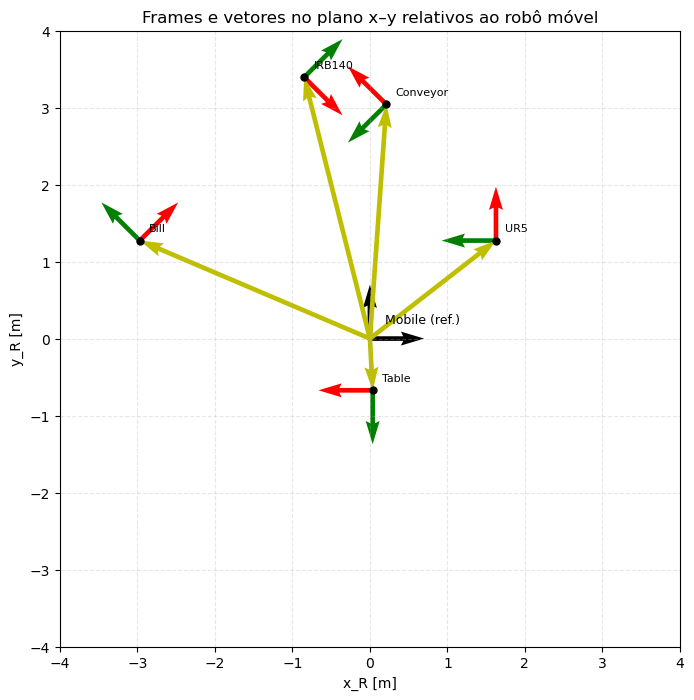

In [32]:
    sim.step()

    # Exemplo 1: posicionar em um ponto único
    set_mobile_xytheta(sim, handleMobileRobot, x=-0.8, y=-1, theta=np.deg2rad(-45))
    sim.step()
    
    poseMobileRobot = sim.getObjectPose(handleMobileRobot, -1)
    T_world_mobile   = htm_se3_from_pose(poseMobileRobot) 

    T_mobile_world = np.linalg.inv(T_world_mobile)
    
    # ^R T_i = (^R T_W) (^W T_i) = ( ^W T_R )^{-1}  (^W T_i)
    T_mobile_ur5      = T_mobile_world @ T_world_ur5
    T_mobile_irb140   = T_mobile_world @ T_world_irb140
    T_mobile_table    = T_mobile_world @ T_world_table
    T_mobile_bill     = T_mobile_world @ T_world_bill
    T_mobile_conveyor = T_mobile_world @ T_world_conveyor
    
    # (opcional) imprimir as HTMs relativas ao robô
    print("Matrizes de transformação homogênea dos objetos em relação ao robô móvel (SE(3), 4x4):\n")
    print("HTM mobile_UR5 (SE(3), 4x4):\n",      T_mobile_ur5,      "\n")
    print("HTM mobile_IRB140 (SE(3), 4x4):\n",   T_mobile_irb140,   "\n")
    print("HTM mobile_Table (SE(3), 4x4):\n",    T_mobile_table,    "\n")
    print("HTM mobile_Bill (SE(3), 4x4):\n",     T_mobile_bill,     "\n")
    print("HTM mobile_Conveyor (SE(3), 4x4):\n", T_mobile_conveyor, "\n")

    # --------- 2) Plot no referencial do robô + 3) vetores OR->Oi ---------
    objetos_R = [
    ("UR5",      T_mobile_ur5),
    ("IRB140",   T_mobile_irb140),
    ("Table",    T_mobile_table),
    ("Bill",     T_mobile_bill),
    ("Conveyor", T_mobile_conveyor),
]
    
    plt.figure(figsize=(8, 8))
    
    # Frame do robô como origem do gráfico
    plot_frame(np.array([0.0, 0.0, 0.0]), Rz(0.0), c=['k','k'])
    plt.text(0.2, 0.2, 'Mobile (ref.)', fontsize=9)
    
    for nome, T in objetos_R:
        x, y, theta = xy_theta_from_T(T)
        Porg  = np.array([x, y, 0.0])
        R2D   = Rz(theta)
    
        # frame do objeto (X vermelho, Y verde)
        plot_frame(Porg, R2D, c=['r','g'])
    
        # marcador e rótulo
        plt.plot(x, y, 'o', color='k', markersize=5)
        plt.text(x + 0.12, y + 0.12, f'{nome}', fontsize=8)
    
        # --- vetor OR -> Oi (transformação do objeto no plano do robô) ---
        # vetor é simplesmente (x,y) no referencial do robô
        plt.quiver(0.0, 0.0, x, y, color='y', angles='xy', scale_units='xy', scale=1)
    
    plt.axis((-4, 4, -4, 4))
    # Ajuste manual de janela, se quiser:
    # plt.axis((-5, 5, -5, 5))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('x_R [m]')   # eixos no frame do robô
    plt.ylabel('y_R [m]')
    plt.title('Frames e vetores no plano x–y relativos ao robô móvel')
    plt.show()


In [33]:
# Retornando para a pose inicial
set_mobile_xytheta(sim, handleMobileRobot, x=-1.5, y=0, theta=np.deg2rad(0))
sim.step()

print('Fim atividade 4')

Fim atividade 4


### Atividade 5: [1,5 pts] Substitua o robô adicionado inicialmente na cena pelo robô com laser mostrado em aula. No exemplo que vimos, o plot da leitura do laser está sendo feito no referencial local do laser. Defina as matrizes de transformações 𝑇𝐿𝑅(laser → robô) e 𝑇𝑅𝑊(robô → mundo), e em seguida modifique o script original para que os pontos agora sejam plotados no referencial global, de acordo com a posição atual do robô (recuperada pela RemoteAPI). Coloque o robô em outras diferentes posições da cena (e.g., três) e faça os plots das leituras do laser. 
### R: Os trechos a seguir realizam as leituras do sensor a partir de 3 poses distintas e plotam os resultados no referencial do mundo.

In [34]:
class HokuyoSensorSim(object):
    """
    Simulates a Hokuyo laser sensor in CoppeliaSim using vision sensors.

    This class provides an interface to interact with a simulated Hokuyo sensor,
    typically attached to a robot in CoppeliaSim. It manages the underlying vision
    sensors and provides methods to retrieve sensor data in either range or point format.

    Attributes:
        _sim: The simulation API object used to interact with CoppeliaSim.
        _base_name (str): The name of the base object to which the Hokuyo sensor is attached.
        _is_range_data (bool): Determines if sensor data is returned as range values (True) or 3D points (False).
        _base_obj: The handle of the base object in the simulation.
        _vision_sensors_obj (list): Handles of the vision sensors used to simulate the Hokuyo sensor.

    Args:
        sim: The simulation API object.
        base_name (str): The name of the base object (must contain 'fastHokuyo').
        is_range_data (bool, optional): If True, sensor data is returned as range values. Defaults to False.

    Raises:
        ValueError: If 'fastHokuyo' is not in the base_name, or if the base object or vision sensors are not found.

    Methods:
        get_is_range_data() -> bool:
            Returns whether sensor data is returned as range values.

        set_is_range_data(is_range_data: bool) -> None:
            Sets whether sensor data should be returned as range values.

        getSensorData():
            Retrieves sensor data from the vision sensors.
            Returns either a list of range values or a list of 3D points, depending on _is_range_data.
    """

    _sim = None

    _base_name = ""
    _vision_sensor_name_template = "{}/sensor{}"

    # _vision_sensors_obj will be initialized in __init__
    _base_obj = None
    _is_range_data = False
    
    _angle_min=-120*math.pi/180
    _angle_max=120*math.pi/180
    _angle_increment=(240/684)*math.pi/180 # angle: 240 deg, pts: 684

    def __init__(self, sim, base_name, is_range_data=True):
        self._sim = sim
        self._base_name = base_name
        self._is_range_data = is_range_data

        if "fastHokuyo" not in base_name:
            raise ValueError(
                f"ERR: fastHokuyo must be in the base object name. Ex: `/PioneerP3DX/fastHokuyo`"
            )

        self._base_obj = sim.getObject(base_name)
        if self._base_obj == -1:
            raise ValueError(
                f"ERR: base_obj ({self._base_obj}) is not a valid name in the simulation"
            )

        self._vision_sensors_obj = [
            sim.getObject(self._vision_sensor_name_template.format(self._base_name, 1)),
            sim.getObject(self._vision_sensor_name_template.format(self._base_name, 2)),
        ]

        if any(obj == -1 for obj in self._vision_sensors_obj):
            raise ValueError(
                f"ERR: the _vision_sensors_obj names are not valid in the simulation"
            )

    def get_is_range_data(self) -> bool:
        return self._is_range_data

    def set_is_range_data(self, is_range_data: bool) -> None:
        self._is_range_data = is_range_data

    def getSensorData(self):
        
        angle = self._angle_min
        sensor_data = []
        
        for vision_sensor in self._vision_sensors_obj:
            r, t, u = sim.readVisionSensor(vision_sensor)
            if u:
                sensorM = sim.getObjectMatrix(vision_sensor)
                relRefM = sim.getObjectMatrix(self._base_obj)
                relRefM = sim.getMatrixInverse(relRefM)
                relRefM = sim.multiplyMatrices(relRefM, sensorM)

                p = [0, 0, 0]
                p = sim.multiplyVector(sensorM, p)
                t = [p[0], p[1], p[2], 0, 0, 0]
                for j in range(int(u[1])):
                    for k in range(int(u[0])):
                        w = 2 + 4 * (j * int(u[0]) + k)
                        v = [u[w], u[w + 1], u[w + 2], u[w + 3]]
                        angle = angle + self._angle_increment
                        if self._is_range_data:
                            sensor_data.append([angle, v[3]])
                        else:
                            p = sim.multiplyVector(relRefM, v)
                            sensor_data.append([p[0], p[1], p[2]])
                            
        return np.array(sensor_data)

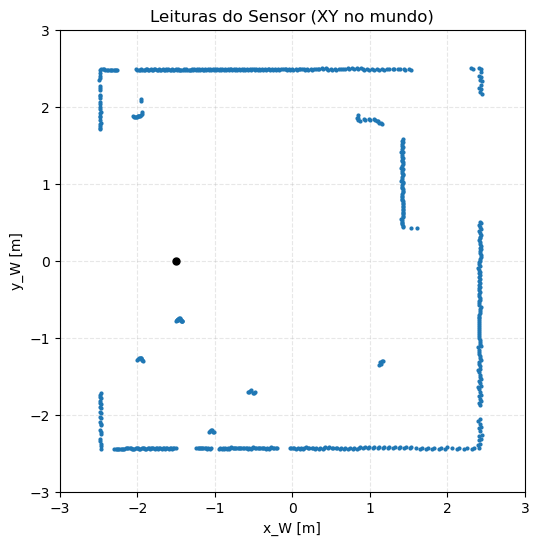

In [35]:
    # Stop if running
    if sim.getSimulationState() != 0:
        sim.stopSimulation()
        time.sleep(0.5)

    # Start
    sim.startSimulation()
    sim.step()

    # --------- (1) SETAR POSE INICIAL DO ROBÔ NO MUNDO ----------
    x0, y0, theta0_deg = -1.5, 0, 0.0   # ajuste como quiser
    theta0 = math.radians(theta0_deg)
    # preserva z atual
    poseR = sim.getObjectPose(handleMobileRobot, -1)  # [x,y,z,qx,qy,qz,qw]
    qx, qy, qz, qw = yaw_to_quaternion(theta0)
    sim.setObjectPose(handleMobileRobot, -1, [x0, y0, poseR[2], qx, qy, qz, qw])
    time.sleep(0.5)
    sim.step()

    # --------- (2) Instanciar o sensor e ler uma varredura ----------
    hokuyo_sensor = HokuyoSensorSim(sim, sensor_base, is_range_data=True)
    laser_data = hokuyo_sensor.getSensorData()   # array Nx2: [ang, dist]

    # --------- (3) Montar ^W T_R e ^R T_S (SE3) ----------
    pose_world_robot   = sim.getObjectPose(handleMobileRobot, -1)
    pose_robot_sensor  = sim.getObjectPose(sensorHandle, handleMobileRobot)
    T_world_robot      = htm_se3_from_pose(pose_world_robot)    # ^W T_R
    T_robot_sensor     = htm_se3_from_pose(pose_robot_sensor)   # ^R T_S
    T_world_sensor     = T_world_robot @ T_robot_sensor         # ^W T_S

    # --------- (4) Transformar laser → mundo e plotar ----------
    fig, ax = plt.subplots(figsize=(6,6))
    XYZ_w = transform_laser_points_to_world(laser_data, T_world_sensor)
    draw_laser_world_xy(ax, XYZ_w, T_world_robot, T_world_sensor, lim=3.0)

    plt.show()
    sim.step()


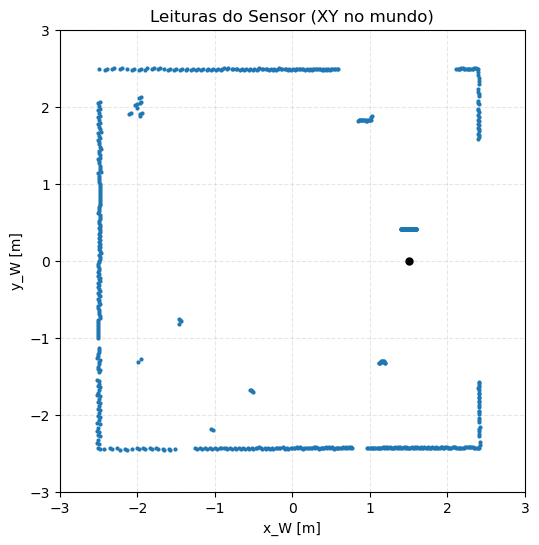

In [36]:
    # --------- (1) SETAR POSE INICIAL DO ROBÔ NO MUNDO ----------
    x0, y0, theta0_deg = 1.5, 0, 180.0   # ajuste como quiser
    theta0 = math.radians(theta0_deg)
    # preserva z atual
    poseR = sim.getObjectPose(handleMobileRobot, -1)  # [x,y,z,qx,qy,qz,qw]
    qx, qy, qz, qw = yaw_to_quaternion(theta0)
    sim.setObjectPose(handleMobileRobot, -1, [x0, y0, poseR[2], qx, qy, qz, qw])
    time.sleep(0.5)
    sim.step()

    # --------- (2) Instanciar o sensor e ler uma varredura ----------
    hokuyo_sensor = HokuyoSensorSim(sim, sensor_base, is_range_data=True)
    laser_data = hokuyo_sensor.getSensorData()   # array Nx2: [ang, dist]

    # --------- (3) Montar ^W T_R e ^R T_S (SE3) ----------
    pose_world_robot   = sim.getObjectPose(handleMobileRobot, -1)
    pose_robot_sensor  = sim.getObjectPose(sensorHandle, handleMobileRobot)
    T_world_robot      = htm_se3_from_pose(pose_world_robot)    # ^W T_R
    T_robot_sensor     = htm_se3_from_pose(pose_robot_sensor)   # ^R T_S
    T_world_sensor     = T_world_robot @ T_robot_sensor         # ^W T_S

    # --------- (4) Transformar laser → mundo e plotar ----------
    fig, ax = plt.subplots(figsize=(6,6))
    XYZ_w = transform_laser_points_to_world(laser_data, T_world_sensor)
    draw_laser_world_xy(ax, XYZ_w, T_world_robot, T_world_sensor, lim=3.0)

    plt.show()
    sim.step()

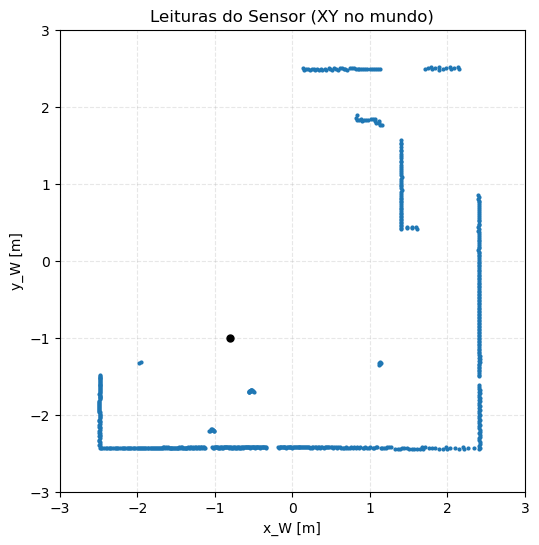

In [37]:
    # --------- (1) SETAR POSE INICIAL DO ROBÔ NO MUNDO ----------
    x0, y0, theta0_deg = -0.8, -1.0, -45.0   # ajuste como quiser
    theta0 = math.radians(theta0_deg)
    # preserva z atual
    poseR = sim.getObjectPose(handleMobileRobot, -1)  # [x,y,z,qx,qy,qz,qw]
    qx, qy, qz, qw = yaw_to_quaternion(theta0)
    sim.setObjectPose(handleMobileRobot, -1, [x0, y0, poseR[2], qx, qy, qz, qw])
    time.sleep(0.5)
    sim.step()

    # --------- (2) Instanciar o sensor e ler uma varredura ----------
    hokuyo_sensor = HokuyoSensorSim(sim, sensor_base, is_range_data=True)
    laser_data = hokuyo_sensor.getSensorData()   # array Nx2: [ang, dist]

    # --------- (3) Montar ^W T_R e ^R T_S (SE3) ----------
    pose_world_robot   = sim.getObjectPose(handleMobileRobot, -1)
    pose_robot_sensor  = sim.getObjectPose(sensorHandle, handleMobileRobot)
    T_world_robot      = htm_se3_from_pose(pose_world_robot)    # ^W T_R
    T_robot_sensor     = htm_se3_from_pose(pose_robot_sensor)   # ^R T_S
    T_world_sensor     = T_world_robot @ T_robot_sensor         # ^W T_S

    # --------- (4) Transformar laser → mundo e plotar ----------
    fig, ax = plt.subplots(figsize=(6,6))
    XYZ_w = transform_laser_points_to_world(laser_data, T_world_sensor)
    draw_laser_world_xy(ax, XYZ_w, T_world_robot, T_world_sensor, lim=3.0)

    sim.step()


In [38]:
# Parando a simulação
set_mobile_xytheta(sim, handleMobileRobot, x=-1.5, y=0, theta=np.deg2rad(0))
sim.step()
sim.stopSimulation()

print('Fim atividade 5')

Fim atividade 5


### Atividade 6: [2,0 pts] Por fim, utilizando o script básico de navegação visto em aula, faça um plot incremental que mostra o caminho executado pelo robô (sequência de posições) ao longo da navegação (por exemplo, usando uma linha tracejada) e combina todas as leituras de laser realizadas ao longo do trajeto. Essas informações devem ser todas representadas em um único gráfico considerando o referencial global. 
### R: Uma janela apresenta o acúmulo das leituras do sensor em um único plot.

In [39]:
#Teste do código do Professor:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

print('Inicio do Programa')
    
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)
    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()


      
    # Fazendo uma leitura do laser
    laser_data = hokuyo_sensor.getSensorData()
    #draw_laser_data(laser_data)
    pose_robot_sensor = sim.getObjectPose(sensorHandle, handleMobileRobot)
    pose__world_sensor = sim.getObjectPose(sensorHandle, -1)
    
    # Posição inicial do robô
    pos = sim.getObjectPosition(handleMobileRobot, sim.handle_world)
    print(f'Posição Inicial do Robô: {pos}')
       
    # Dados do Pioneer
    L = 0.381  # Metros
    r = 0.0975 # Metros

    %matplotlib qt
    plt.ion()
    fig, ax = plt.subplots(figsize=(6,6))
    print("Iniciando o Loop de Controle...")
    while (sim_time := sim.getSimulationTime()) < 30:

        # Fazendo leitura do laser
        laser_data = hokuyo_sensor.getSensorData()

        #Testes do plot
        pose__world_sensor = sim.getObjectPose(sensorHandle, -1)
        T_world_robot = htm_se3_from_pose(pose_world_robot)
        T_world_sensor = htm_se3_from_pose(pose__world_sensor)
        XYZ_w = transform_laser_points_to_world(laser_data, T_world_sensor)
    
        #ax.clear() # Limpa para não sobrecarregar o plot (opcional)
        draw_laser_world_xy(ax, XYZ_w, T_world_robot, T_world_sensor, lim=3.0)
        #plt.draw()
        sim.step()        

        # Velocidade básica (linear, angular)
        v = 0
        w = np.deg2rad(0)

        frente = int(len(laser_data) / 2)
        lado_direito = int(len(laser_data) * 1 / 4)
        lado_esquerdo = int(len(laser_data) * 3 / 4)

        # Lógica de desvio de obstáculo
        if laser_data[frente, 1] > 2:
            v = .5
            w = 0
        elif laser_data[lado_direito, 1] > 2:
            v = 0
            w = np.deg2rad(-30)
        elif laser_data[lado_esquerdo, 1] > 2:
            v = 0
            w = np.deg2rad(30)

        # Modelo cinemático
        wl = v / r - (w * L) / (2 * r)
        wr = v / r + (w * L) / (2 * r)

        # Enviando velocidades (não precisa mais de opmode)
        sim.setJointTargetVelocity(l_wheel, wl)
        sim.setJointTargetVelocity(r_wheel, wr)

        sim.step()

    # Parando o robô
    print("Parando o Robô...")
    sim.setJointTargetVelocity(r_wheel, 0)
    sim.setJointTargetVelocity(l_wheel, 0)

except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
plt.ioff()  # desliga modo interativo
plt.show()
sim.stopSimulation()

print('Fim da Atividade 6')

Inicio do Programa
Posição Inicial do Robô: [-1.5002519262788718, -5.501470642803805e-05, 0.13867950838089207]
Iniciando o Loop de Controle...
Parando o Robô...
Fim da Atividade 6


In [40]:
#%matplotlib inline